<a href="https://colab.research.google.com/github/US30/Mnist_Diffusion/blob/main/MNIST_Diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Utkarsh Sinha D019

In [ ]:
%%capture
!pip install diffusers[training]==0.2.3
!pip install "ipywidgets>=7,<8"

In [ ]:
# Imports

# Pytorch
import torch
import torchvision

# HuggingFace
import datasets
import diffusers
import accelerate

# Training and Visualization
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import os
import PIL

In [ ]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size=32 #Resize the digits to be a power of two
    train_batch_size = 32
    eval_batch_size = 32
    num_epochs = 5
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmpup_steps = 500
    mixed_precision = 'fp16'
    seed = 0

config = TrainingConfig()

In [ ]:
mnist_dataset = datasets.load_dataset('mnist', split='train')

README.md: 0.00B [00:00, ?B/s]

mnist/train-00000-of-00001.parquet:   0%|          | 0.00/15.6M [00:00<?, ?B/s]

mnist/test-00000-of-00001.parquet:   0%|          | 0.00/2.60M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
mnist_dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 60000
})

In [ ]:
mnist_dataset[0]["image"].resize((256, 256)).show()
print("Image Size:", mnist_dataset[0]["image"].size)
print("Digit is labelled:", mnist_dataset[0]['label'])

Image Size: (28, 28)
Digit is labelled: 5


In [ ]:
def transform(dataset):
    preprocess = torchvision.transforms.Compose(
        [
            torchvision.transforms.Resize(
                (config.image_size, config.image_size)),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Lambda(lambda x: 2*(x-0.5)),
        ]
    )
    images = [preprocess(image) for image in dataset["image"]]
    return {"images": images}

In [ ]:
mnist_dataset.reset_format()
mnist_dataset.set_transform(transform)

In [ ]:
train_dataloader = torch.utils.data.DataLoader(
    mnist_dataset,
    batch_size = config.train_batch_size,
    shuffle = True,
)

In [ ]:
model = diffusers.UNet2DModel(
    sample_size=config.image_size,
    in_channels=1,
    out_channels=1,
    layers_per_block=2,
    block_out_channels=(128,128,256,512),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

In [ ]:
sample_image = mnist_dataset[0]["images"].unsqueeze(0)
print("Input shape:", sample_image.shape)

Input shape: torch.Size([1, 1, 32, 32])


In [ ]:
print('Output shape:', model(sample_image, timestep=0)["sample"].shape)

Output shape: torch.Size([1, 1, 32, 32])


In [ ]:
noise_scheduler = diffusers.DDPMScheduler(num_train_timesteps=200, tensor_format='pt')

Original Digit


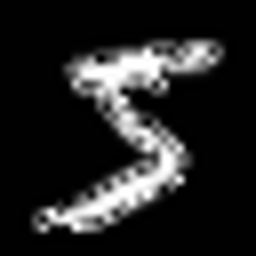

In [ ]:
print("Original Digit")
torchvision.transforms.ToPILImage()(sample_image.squeeze(1)).resize((256,256))

Fully Noised Digit


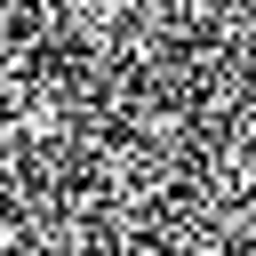

In [ ]:
noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([199])
noisy_image = noise_scheduler.add_noise(sample_image,noise,timesteps)

print("Fully Noised Digit")
torchvision.transforms.ToPILImage()(noisy_image.squeeze(1)).resize((256,256))

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(),lr=config.learning_rate)

In [ ]:
# Cosine learning rate scheduler

lr_scheduler = diffusers.optimization.get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmpup_steps,
    num_training_steps=(len(train_dataloader)*config.num_epochs),
)

In [ ]:
import torch
import accelerate
from tqdm.auto import tqdm

def train_loop(
        config,
        model,
        noise_scheduler,
        optimizer,
        train_dataloader):

    accelerator = accelerate.Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
    )

    model, optimizer, train_dataloader = accelerator.prepare(
        model, optimizer, train_dataloader
    )

    # Cosine learning rate scheduler
    lr_scheduler = diffusers.optimization.get_cosine_schedule_with_warmup(
        optimizer=optimizer,
        num_warmup_steps=config.lr_warmpup_steps,
        num_training_steps=(len(train_dataloader)*config.num_epochs),
    )


    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader),
                            disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch['images']
            noise = torch.randn(clean_images.shape).to(clean_images.device)
            batch_size = clean_images.shape[0]

            # --- START: THE FIX ---

            # 1. Create timesteps on CPU (by *not* specifying a device).
            #    The scheduler (which is on the CPU) needs this.
            timesteps = torch.randint(
                0, noise_scheduler.num_train_timesteps, (batch_size,)
            ).long() # Use .long() for indices

            # 2. Add noise. This call now works because both the
            #    scheduler and 'timesteps' are on the CPU.
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            # --- END: THE FIX ---

            with accelerator.accumulate(model):

                # 3. Move timesteps to the GPU right before the model call.
                #    The model (which is on the GPU) needs this.
                noise_pred = model(noisy_images, timesteps.to(clean_images.device))["sample"]

                loss = torch.nn.functional.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {
                "loss" : loss.detach().item(),
                "lr" : lr_scheduler.get_last_lr()[0],
            }
            progress_bar.set_postfix(**logs)

    accelerator.unwrap_model(model)

In [ ]:
args = (config, model, noise_scheduler, optimizer, train_dataloader)

accelerate.notebook_launcher(train_loop, args, num_processes=1)

Launching training on one GPU.


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

In [ ]:
@torch.no_grad()
def sample(unet, scheduler,seed,save_process_dir=None):
    torch.manual_seed(seed)

    if save_process_dir:
        if not os.path.exists(save_process_dir):
            os.mkdir(save_process_dir)

    scheduler.set_timesteps(1000)
    image=torch.randn((1,1,32,32)).to(model.device)
    num_steps=max(noise_scheduler.timesteps).numpy()

    for t in noise_scheduler.timesteps:
        model_output=unet(image,t)['sample']
        image=scheduler.step(model_output,int(t),image,generator=None)['prev_sample']
        if save_process_dir:
            save_image=torchvision.transforms.ToPILImage()(image.squeeze(0))
            save_image.resize((256,256)).save(
                os.path.join(save_process_dir,"seed-"+str(seed)+"_"+f"{num_steps-t.numpy():03d}"+".png"),format="png")

    return torchvision.transforms.ToPILImage()(image.squeeze(0))

## Sample some good looking digits!

Some samples look quit good...

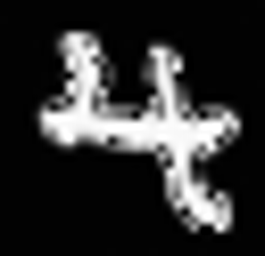

In [ ]:
test_image=sample(model,noise_scheduler,2)
test_image.resize((265,256))

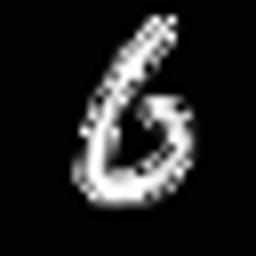

In [ ]:
test_image=sample(model,noise_scheduler,5)
test_image.resize((256,256))

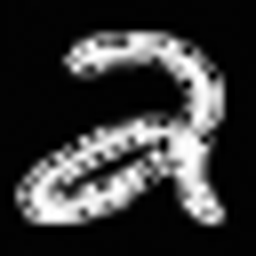

In [ ]:
test_image=sample(model,noise_scheduler,1991)
test_image.resize((256,256))

But others aren't quite recognizable as a number, but look like they *could* be number if things went just slightly differently...

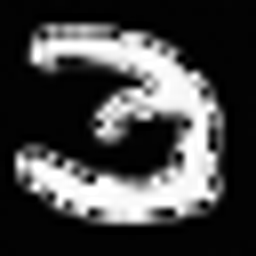

In [ ]:
test_image=sample(model,noise_scheduler,2022)
test_image.resize((256,256))

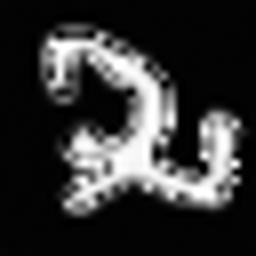

In [ ]:
test_image=sample(model,noise_scheduler,42)
test_image.resize((256,256))